# Machine Learning

In [43]:
import pandas as pd
import os

piano_paths = [ './data/piano/' + path for path in os.listdir('./data/piano')]
violin_paths = [ './data/violin/' + path for path in os.listdir('./data/violin')]
drums_paths = [ './data/drums/' + path for path in os.listdir('./data/drums')]
guitar_paths = [ './data/guitar/' + path for path in os.listdir('./data/guitar')]

df_1 = pd.DataFrame(data={"path": guitar_paths, "label": np.zeros(len(guitar_paths))})
df_2 = pd.DataFrame(data={"path": piano_paths, "label": np.zeros(len(piano_paths)) + 1})
df_3 = pd.DataFrame(data={"path": violin_paths, "label": np.zeros(len(violin_paths)) + 2})
df_4 = pd.DataFrame(data={"path": drums_paths, "label": np.zeros(len(drums_paths)) + 3})

df = pd.concat((df_1,df_2,df_3,df_4), axis=0).reset_index(drop=True)
df_sample = df.sample(len(piano_paths) + len(violin_paths) + len(drums_paths) + len(guitar_paths))

df_sample

,path,label
2213,./data/drums/glitch-beat-001-128-bpm-99953.wav,3.0
1194,./data/piano/ROOM_room7_MUS_pachelbel_DEV_ster...,1.0
1487,./data/violin/violin_sound (181).wav,2.0
1785,./data/violin/violin_sounds (2).wav,2.0
2413,./data/drums/WaveDrum02_45SD (124).wav,3.0
...,...,...
1870,./data/violin/2_oliver-colbentson_bwv1006_mov1...,2.0
1635,./data/violin/VIOLIN_sound (320).wav,2.0
259,./data/guitar/G53-48108-1111-165.wav,0.0
142,./data/guitar/slow_folk_3_130BPM.wav,0.0


In [44]:
def feature_extraction(audio, sr, label):
    #Spectral Centroids
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr).mean()
    
    #Zero Crossings
    zero_crossings = librosa.zero_crossings(audio, pad=False).mean()

    #Spectral Rolloff
    rolloff_mean = librosa.feature.spectral_rolloff(y=audio, sr=sr).mean()
    rmse_mean = librosa.feature.rms(y=audio).reshape(-1).mean()
    
    #Mfccs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mels=15, n_fft=2048//2)
    mfccs_mean = mfccs.mean(axis=1)
    #mfccs_std = mfccs.std(axis=1)

    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr).mean(axis=1)

    #Chroma
    chroma_mean = librosa.feature.chroma_vqt(y=audio, sr=sr, intervals="equal").mean(axis=1)

    #Flatness
    flatness = librosa.feature.spectral_flatness(y=audio).mean()
    
    return [spectral_centroids, rolloff_mean, zero_crossings, flatness, *contrast, *mfccs_mean,  *chroma_mean, label]

In [56]:
import os 

all_features = []

j = 0

for i, (file, label) in df_sample.iterrows():
    print(file)
    audio, sr = librosa.load(file, sr=44100)
    features = feature_extraction(audio, sr, label)
    all_features.append(features)  
    if j % 10 == 0:
        print(j)

    break
    j+=1
        
all_features = np.array(all_features)
all_features

./data/drums/glitch-beat-001-128-bpm-99953.wav
0


array([[ 3.41941891e+03,  6.42448679e+03,  9.42383799e-02,
         3.92189249e-05,  1.47811665e+01,  6.92266294e+00,
         8.05993426e+00,  1.21290390e+01,  1.27650944e+01,
         1.59210643e+01,  6.69924239e+01, -1.20407959e+02,
         2.66280460e+01, -3.14556265e+00,  3.21984634e+01,
        -6.55021143e+00,  2.20452328e+01, -3.40677834e+00,
         1.32287474e+01, -1.69414973e+00,  7.20673132e+00,
         9.45796907e-01,  5.51760769e+00,  1.99944973e+00,
         1.89734447e+00,  2.34754145e-01,  7.87333786e-01,
         9.22071576e-01,  8.06294799e-01,  7.29921341e-01,
         7.61927307e-01,  6.78505659e-01,  6.58824265e-01,
         7.04975605e-01,  6.76971138e-01,  4.15457308e-01,
         3.54534000e-01,  3.86828005e-01,  3.00000000e+00]])

In [57]:
#Save to file
#df = pd.DataFrame(all_features)
#df.to_csv('./data/features.csv')
df = pd.read_csv('./data/features.csv')

In [58]:
df.shape

(2615, 40)

In [59]:
from pyod.models.hbos import HBOS
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD

X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().astype(int)

model = ABOD(contamination=0.02)
model.fit(X)
y_test_scores = model.decision_function(X)
y_test_pred = model.predict(X)
inlier_indices = np.argwhere(y_test_pred == 0).T[0]


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X[inlier_indices], y[inlier_indices], test_size=0.2, random_state=42)

# Neural Network



In [61]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.utils.data import DataLoader
import random
from sklearn.model_selection import KFold



In [62]:
X_train = torch.tensor(X_train).to(torch.float32)
y_train = torch.tensor(y_train)

In [63]:
X_test = torch.tensor(X_test).to(torch.float32)
y_test = torch.tensor(y_test)

In [64]:
X_train[:, 1:].shape

torch.Size([2050, 38])

In [65]:
X_train.shape[1]

39

In [386]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train.shape[1], 25),
            nn.ReLU(),
            nn.Linear(25, 15),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(15, 4),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


torch.use_deterministic_algorithms(True)
torch.manual_seed(42)

# Set a seed for NumPy
np.random.seed(42)

# Set a seed for Python's built-in random module
random.seed(42)

# Check if CUDA (GPU) is available and set a seed for it
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


lr = 0.001
epochs = 1591


net = Network()
net.train()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

loss_curve = []
train_curve = []
test_curve = []
for i in range(epochs):
    optimizer.zero_grad()
    pred = net(X_train)
    loss = loss_fn(pred, y_train)
    
    loss.backward()
    optimizer.step()
    loss_curve.append(loss.item())
    train_curve.append(((y_train == net(X_train).max(axis=1)[1]).sum()/y_train.shape[0]).item())
    test_curve.append(((y_test == net(X_test).max(axis=1)[1]).sum()/y_test.shape[0]).item())

    if i % 100 == 0:
        print(loss.item())

net.eval()


1.3911335468292236
0.5608007907867432
0.25153645873069763
0.1594042032957077
0.11927435547113419
0.09237854927778244
0.08010634034872055
0.07327760010957718
0.061899583786726
0.052248694002628326
0.045944780111312866
0.039317935705184937
0.03400692716240883
0.03219311311841011
0.029306666925549507
0.028924226760864258


Network(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=39, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=15, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=15, out_features=4, bias=True)
  )
)

In [387]:
#torch.save(net.state_dict(), './model_weights.pt')

In [397]:
print(np.array(test_curve).argmax()+1, "Epochs highest")
print(np.array(test_curve).max(), "Highest score")

1591 Epochs highest
0.988304078578949 Highest score


In [389]:
test_curve[-1]

0.988304078578949

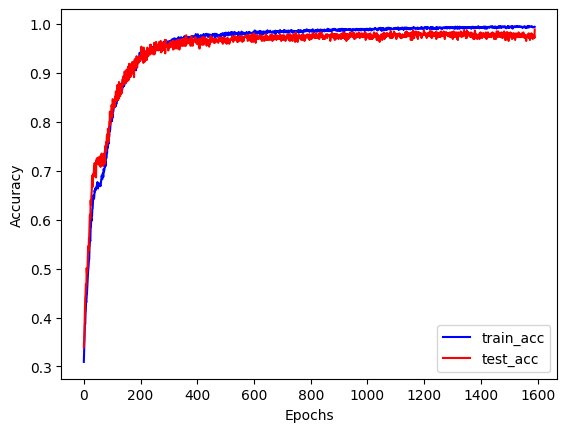

In [392]:
import seaborn as sns 
sns.lineplot(train_curve, color="blue", label="train_acc")
sns.lineplot(test_curve, color="red", label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("train-test-accuracy.png")

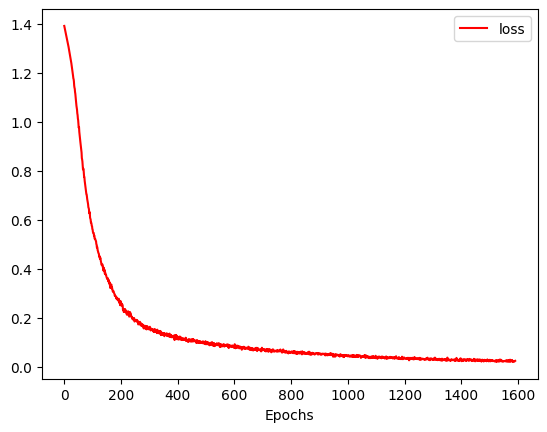

In [394]:
sns.lineplot(loss_curve, color="red", label="loss")
plt.xlabel("Epochs")
plt.savefig("loss.png")

In [395]:
(y_train == net(X_train).max(axis=1)[1]).sum()/y_train.shape[0]

tensor(0.9951)

In [396]:
(y_test == net(X_test).max(axis=1)[1]).sum()/y_test.shape[0]

tensor(0.9805)

In [313]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [314]:
labels = np.array([0,1,2,3])
labels

array([0, 1, 2, 3])

In [315]:
def label_to_class(label):
    if label == "Sound_Guitar":
        return 0

    if label == "Sound_Piano":
        return 1

    if label == "Sound_Violin":
        return 2

    if label == "Sound_Drum":
        return 3

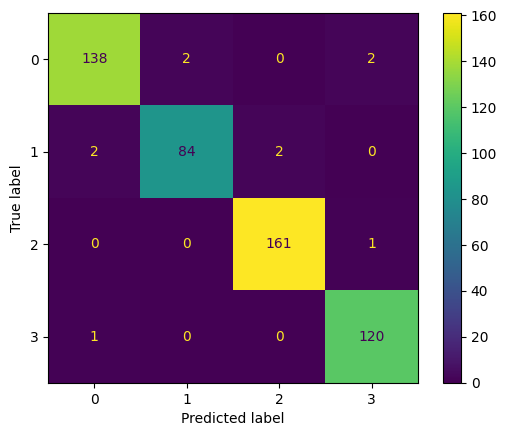

In [402]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=y_test, y_pred=net(X_test).max(axis=1)[1], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
disp.figure_.savefig("./good_confusion_matrix.png",dpi=300)

<Figure size 640x480 with 0 Axes>